In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ARTHRITIS','ASD','AUD','BILIARYCHIRROSIS','BPD','CHRONICPAIN','CUD','ENDOMETRIOSIS','EPILEPSY','FATIGUE','FIBROMYALGIA','GDM','GH','GOUT','HOARDING','IBD','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PCOS','PREECLAMPSIA','PRETERMBIRTH','PTSD','SJOGRENS','SZC','THYROID','TS']

In [4]:
len(disorders)

37

In [4]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [6]:
len(ex_table_files)

36

In [5]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [8]:
len(df_list)

36

In [14]:
def make_correlation_matrix2(column, df_list):
    n = len(df_list) +1
    array = np.zeros((n, n))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            # Extract values of 'rg' column to a list
            rg_values = list(val)

            # Fill the matrix starting from below the diagonal
            for j in range(i + 1, n):
                array[j, i] = rg_values.pop(0)

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else:
        np.fill_diagonal(array, 0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)
    
    # Set values outside [-1, 1] to NaN
    array[(array > 1) | (array < -1)] = np.nan
    
    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array


In [15]:
#corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix2('rg', df_list)

In [16]:
gen_corr_df.describe()

,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARYCHIRROSIS,BPD,CHRONICPAIN,CUD,...,PANIC,PARKINSONS,PCOS,PREECLAMPSIA,PRETERMBIRTH,PTSD,SJOGRENS,SZC,THYROID,TS
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,36.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.192797,-0.017976,0.222576,0.057297,0.097549,0.110359,0.032749,0.099922,0.161000,0.095419,...,0.054632,0.080643,0.021246,0.020486,0.082594,0.036092,0.055822,0.029895,0.030378,0.027027
std,0.246548,0.217755,0.294024,0.220522,0.213431,0.222109,0.189490,0.218685,0.228365,0.242825,...,0.184740,0.215123,0.177462,0.168549,0.248198,0.178271,0.217588,0.165357,0.165095,0.164399
min,-0.141500,-0.446100,-0.370300,-0.373200,-0.259200,-0.116800,-0.250400,-0.144000,-0.114500,-0.134100,...,-0.095700,0.000000,-0.298000,-0.174200,0.000000,-0.170200,-0.081600,-0.023700,0.000000,0.000000
25%,0.027800,-0.125400,0.000000,-0.047700,0.000000,-0.008800,-0.022700,-0.003500,0.000000,-0.004200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.141800,-0.029200,0.186800,0.000000,0.066100,0.046600,0.000000,0.016600,0.115500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.248200,0.045400,0.363700,0.086000,0.142500,0.157100,0.077700,0.123100,0.261800,0.116500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
gen_corr_df.fillna(0, inplace=True)

In [19]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)
full_df = full_df.clip(lower=-1, upper=1)

In [14]:
""" full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True) """

" full_df.to_csv('genetic_correlation.csv', header=True, index=True)\ngen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True) "

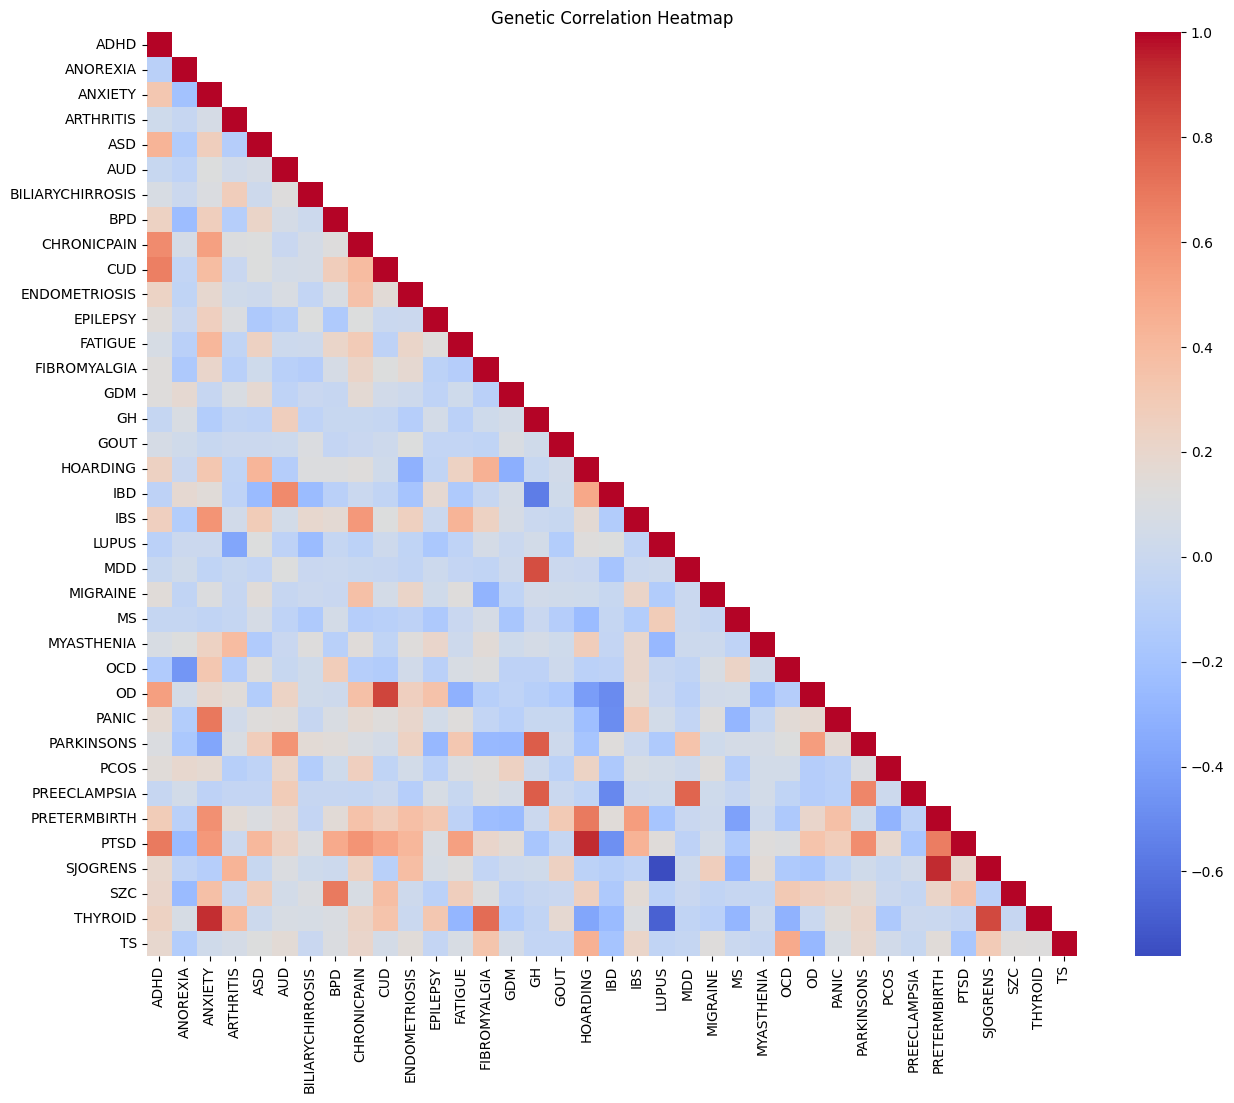

In [20]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
heatmap= sns.heatmap(gen_corr_df, cmap='coolwarm',mask=mask)

plt.title('Genetic Correlation Heatmap')
plt.show()



<Figure size 2000x2000 with 0 Axes>

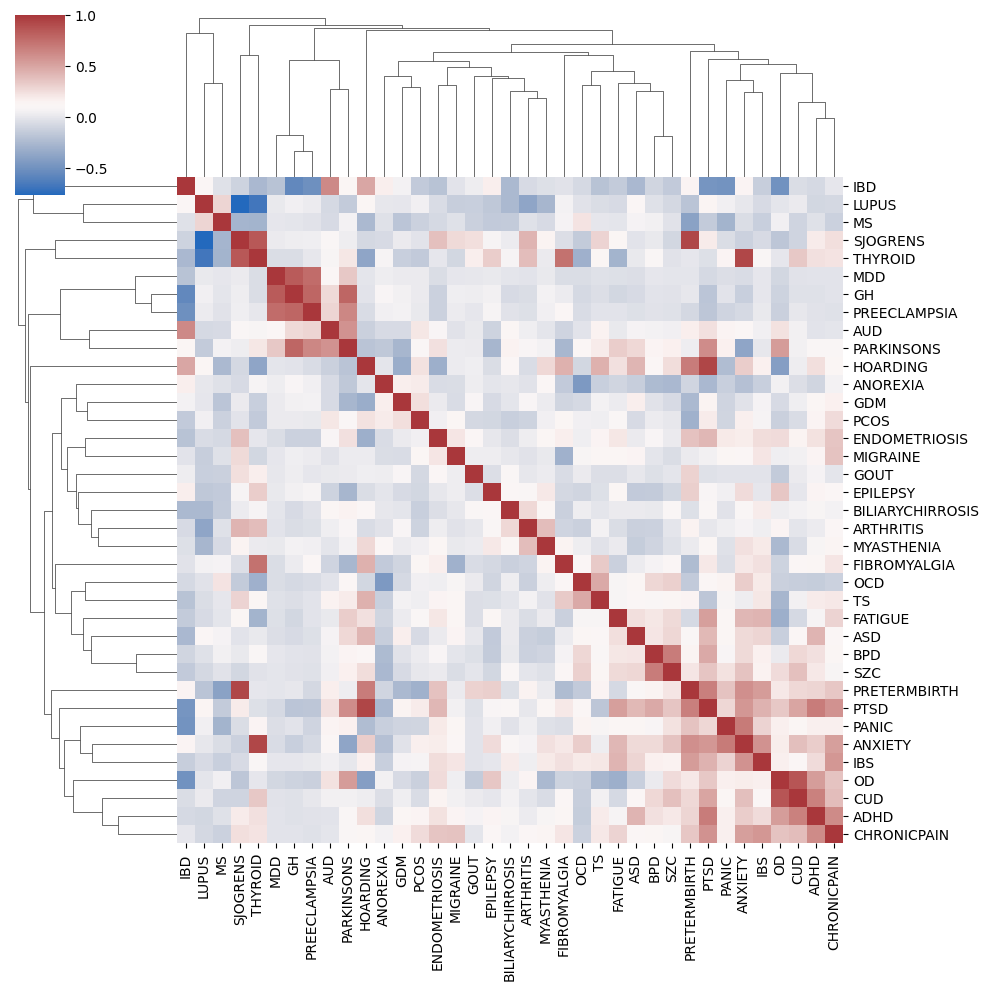

In [21]:
#plot clustermap
plt.figure(figsize=(20,20))
sns.clustermap(full_df,cmap='vlag', method='average', metric='euclidean')
plt.show()

<Figure size 2000x2000 with 0 Axes>

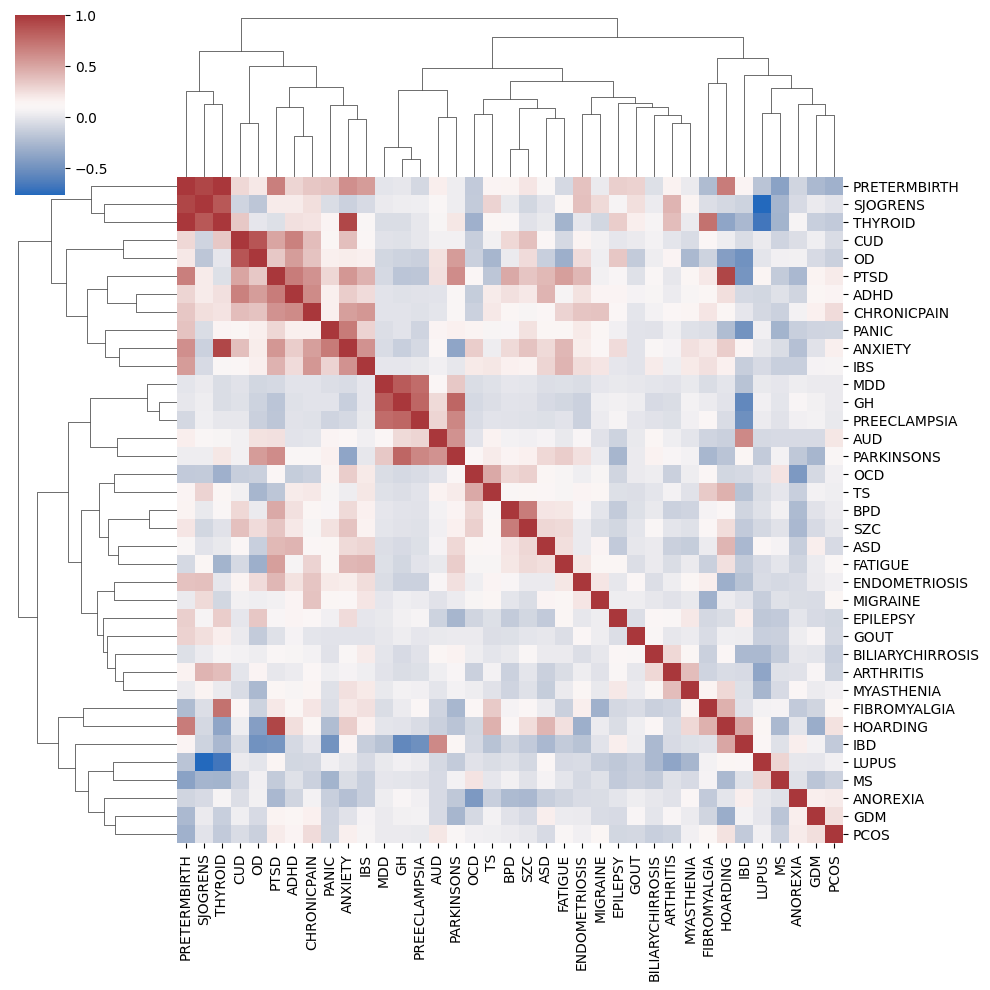

In [12]:
#plot clustermap
plt.figure(figsize=(20,20))
sns.clustermap(full_df,cmap='vlag', method='complete')
plt.show()

<Figure size 2000x2000 with 0 Axes>

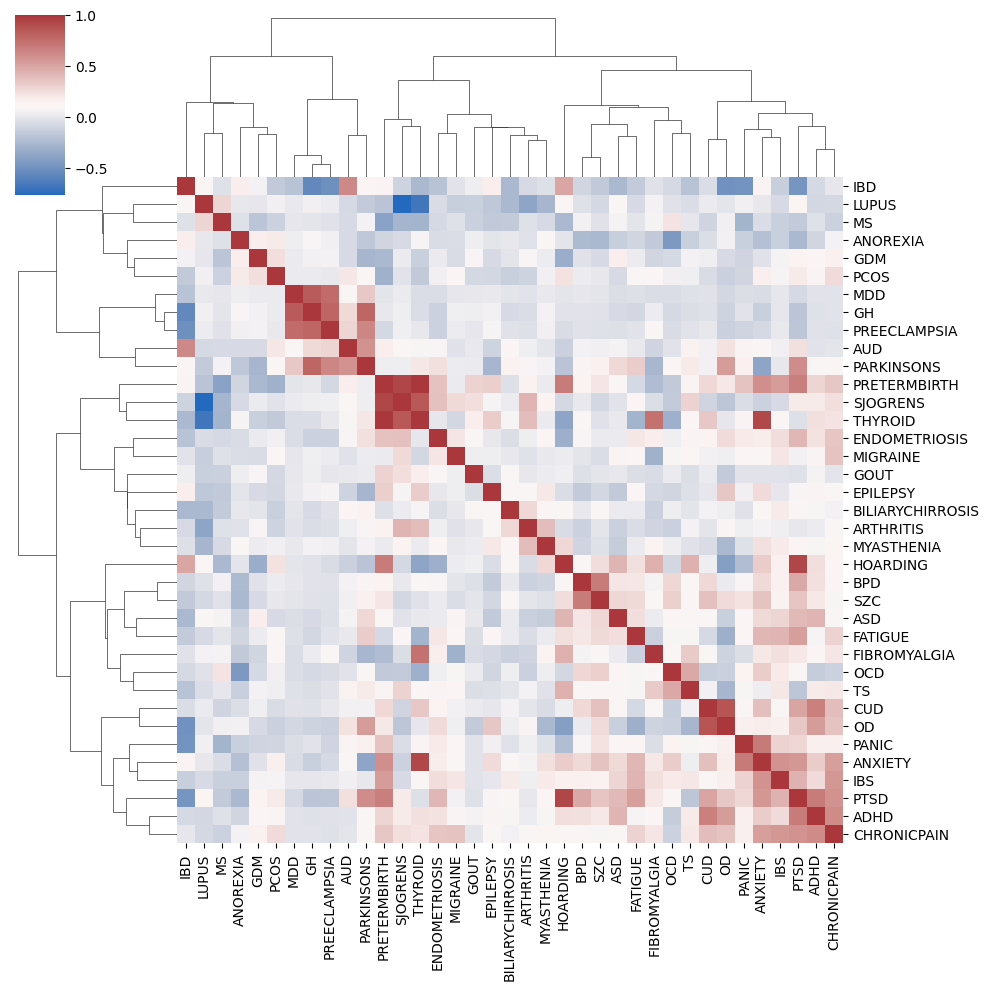

In [13]:
#plot clustermap
plt.figure(figsize=(20,20))
sns.clustermap(full_df,cmap='vlag', method='ward', metric='euclidean')
plt.show()